In [1]:
import numpy as np
import matplotlib.pyplot as plt
%run Grid_world.ipynb
import import_ipynb
from Iterative_Policy_Evaluation import print_values, print_policy, fixed_policy

importing Jupyter notebook from Iterative Policy Evaluation.ipynb


In [2]:
SMALL_ENOUGH = 1e-5
GAMMA = 0.9
ALL_POSSIBLE_ACTIONS = ('U', 'D', 'L', 'R')


In [20]:
def random_action(a, eps=0.2):
    """Chose the given action with probability (1- eps) and choose randomly otherwise."""
    p = np.random.random()
    if p < (1-eps):
        return a
    else:
        return np.random.choice(ALL_POSSIBLE_ACTIONS)

In [21]:
def play_game(grid, policy, start_pos=(2,0)):
    """Returns the state, action, returns tuple for each state encountered in the episode"""
    
    
    #Start form fixed position everytime
    grid.set_state(start_pos)
    s = grid.current_state()
    
    #Chose action using random action function (epsilon-greedy)
    action = random_action(policy[s])
       
    states_actions_rewards = [(s,action,0.0)] #Assign zero reward to starting state and action
    #Play game using the policy and collect states and rewards
    seen_states = set()
    seen_states.add(s)
    num_steps = 0
    while not grid.game_over():
        num_steps += 1
        old_state = s
        reward = grid.move(action)
        s = grid.current_state()
        
        if s in seen_states:  #Terminate episode if the states run into a loop
            states_actions_rewards.append((s,None, -10.0/num_steps))
            break
        elif grid.game_over():
            states_actions_rewards.append((s,None, reward))
            break
        else:
            action = random_action(policy[s])
            states_actions_rewards.append((s,action,reward))
        seen_states.add(s)
            
    states_actions_returns = []    
    G = 0
    first = True
    for s,a,r in reversed(states_actions_rewards):
    # the value of the terminal state is 0 by definition
    # we should ignore the first state we encounter
    # and ignore the last G, which is meaningless since it doesn't correspond to any move
        if first:
            G = 0 #Terminal state has no future reward
            first = False
        else:
            states_actions_returns.append((s,a,G))
        G = r + GAMMA*G
    
    states_actions_returns.reverse()
    return states_actions_returns

In [22]:
def max_dict(d):
    # returns the argmax (key) and max (value) from a dictionary
    # put this into a function since we are using it so often
    max_key = None
    max_val = float('-inf')
    for k, v in d.items():
        if v > max_val:
            max_val = v
            max_key = k
    return max_key, max_val

rewards:
---------------------------
-0.10|-0.10|-0.10| 1.00|
---------------------------
-0.10| 0.00|-0.10|-1.00|
---------------------------
-0.10|-0.10|-0.10|-0.10|

Initial random policy:
---------------------------
  U  |  R  |  D  |     |
---------------------------
  U  |     |  U  |     |
---------------------------
  D  |  U  |  L  |  L  |

Final policy:
---------------------------
  R  |  R  |  R  |     |
---------------------------
  U  |     |  U  |     |
---------------------------
  U  |  R  |  U  |  U  |

Final values:
---------------------------
-0.11| 0.41| 1.00| 0.00|
---------------------------
-0.64| 0.00|-0.44| 0.00|
---------------------------
-1.26|-0.62|-0.24|-1.00|


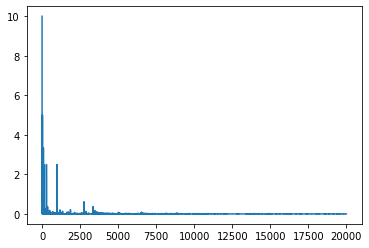

In [23]:
if __name__ ==  "__main__":
    grid = negative_grid()
    
    # print rewards
    print("rewards:")
    print_values(grid.rewards, grid)
    
    #Randomly generate a policy
    policy = {}
    for s in grid.actions.keys():
        policy[s] = np.random.choice(ALL_POSSIBLE_ACTIONS)
    
    print("\nInitial random policy:")
    print_policy(policy, grid)
    
    # initialize Q(s,a) and returns for all possible states and actions
    Q = {}
    returns = {} # dictionary of state -> list of returns we've received
    states = grid.all_states()
    for s in states:
        if s in grid.actions: # not a terminal state
            Q[s] = {}
            for a in ALL_POSSIBLE_ACTIONS:
                Q[s][a] = 0 # needs to be initialized to something so we can argmax it
                returns[(s,a)] = []
        else:
           # terminal state or state we can't otherwise get to
           pass
    
    #play games, avg the returns and update policy
    deltas = []
    min_itr = -100
    for i in range(20000):
        biggest_change = 0
        states_actions_returns = play_game(grid,policy,start_pos=(2,0))
        seen_states_actions = set()
        for s, a, G in states_actions_returns:
          # check if we have already seen s
          # called "first-visit" MC policy evaluation
            if (s,a) not in seen_states_actions:
                old_q = Q[s][a]
                returns[(s,a)].append(G)
                Q[s][a] = np.mean(returns[(s,a)])
                biggest_change = max(biggest_change, np.abs(old_q - Q[s][a]))
                seen_states_actions.add((s,a))
        
        if (biggest_change < SMALL_ENOUGH) & (min_itr < 0):
            min_itr = i
            
        deltas.append(biggest_change)
        
        #Policy Update, happens for each episode
        for s in policy.keys():
            policy[s] = max_dict(Q[s])[0]
            
            
    # final Policy
    print("\nFinal policy:")
    print_policy(policy, grid)
    
    # find V
    V = {}
    for s, Qs in Q.items():
        V[s] = max_dict(Q[s])[1]

    #print("Min Iterations needed", min_itr)    
    print("\nFinal values:")
    print_values(V, grid)
    
    plt.plot(deltas)
    plt.show()